In [4]:
# retrain_lstm_autoencoder.py
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# ---------- CONFIG ----------
   # <--- change to your CSV file path if needed
LABEL_COL = "Label"     # adjust if your label column is named differently
CORR_THRESHOLD = 0.95   # drop one of pair with abs(corr) > this
RANDOM_STATE = 42
EPOCHS = 30
BATCH_SIZE = 512
PATIENCE = 5
THRESHOLD_PERCENTILE = 99  # 95th percentile used as default threshold
MODEL_OUT = "lstm_autoencoder.h5"
SCALER_OUT = "scaler.pkl"
FEATURES_OUT = "numeric_features.json"
THRESHOLD_OUT = "threshold.json"

In [6]:
# ---------- LOAD ----------
import pandas as pd


df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\Real-Time-Anomaly-Detection-in-IoMT-Device-Communication-1\data.csv')
print("Original shape:", df.shape)
print("Label distribution:\n", df[LABEL_COL].value_counts())


Original shape: (428161, 40)
Label distribution:
 Label
DDOS-ICMP_FLOOD            65637
DDOS-UDP_FLOOD             49192
DDOS-TCP_FLOOD             40820
DDOS-PSHACK_FLOOD          37600
DDOS-SYN_FLOOD             37033
DDOS-RSTFINFLOOD           36744
DDOS-SYNONYMOUSIP_FLOOD    32539
DOS-UDP_FLOOD              30141
DOS-TCP_FLOOD              24161
DOS-SYN_FLOOD              18595
BENIGN                     10181
MIRAI-GREETH_FLOOD          9107
MIRAI-UDPPLAIN              7990
MIRAI-GREIP_FLOOD           6902
DDOS-ICMP_FRAGMENTATION     4085
VULNERABILITYSCAN           3372
MITM-ARPSPOOFING            2848
DDOS-UDP_FRAGMENTATION      2695
DDOS-ACK_FRAGMENTATION      2619
DNS_SPOOFING                1590
RECON-HOSTDISCOVERY         1231
RECON-OSSCAN                 850
RECON-PORTSCAN               726
DOS-HTTP_FLOOD               643
DDOS-HTTP_FLOOD              254
DDOS-SLOWLORIS               205
DICTIONARYBRUTEFORCE         116
BROWSERHIJACKING              74
COMMANDINJECTION    

In [7]:
# ---------- SELECT NUMERIC FEATURES ----------
# Exclude label and any obvious non-numeric columns if present
cols = df.columns.tolist()
if LABEL_COL not in cols:
    raise RuntimeError(f"Label column '{LABEL_COL}' not found in CSV columns: {cols[:10]}...")

# Candidate numeric features = all columns except label
numeric_candidates = [c for c in cols if c != LABEL_COL]

# Convert candidate columns to numeric where possible (coerce errors to NaN)
for c in numeric_candidates:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop columns that are entirely NaN (if any)
allnan = [c for c in numeric_candidates if df[c].isna().all()]
if allnan:
    print("Dropping columns with all-NaN:", allnan)
    numeric_candidates = [c for c in numeric_candidates if c not in allnan]

# For safety, fill remaining NaNs with 0 (you may choose mean/median if preferred)
df[numeric_candidates] = df[numeric_candidates].fillna(0)

In [8]:
# ---------- Remove highly correlated features ----------
import numpy as np


corr = df[numeric_candidates].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESHOLD)]
if to_drop:
    print(f"Dropping {len(to_drop)} highly correlated features (threshold={CORR_THRESHOLD}):")
    print(to_drop)
numeric_features = [c for c in numeric_candidates if c not in to_drop]

print("Final numeric feature count:", len(numeric_features))
print(numeric_features)

Dropping 8 highly correlated features (threshold=0.95):
['rst_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'IPv', 'LLC', 'Tot size']
Final numeric feature count: 31
['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [9]:
# ---------- Build train/val/test splits ----------
# Separate benign (normal) and anomaly
benign_df = df[df[LABEL_COL].str.contains("Benign", case=False, na=False)].copy()
anom_df = df[~df[LABEL_COL].str.contains("Benign", case=False, na=False)].copy()

print("Benign count:", len(benign_df))
print("Anomaly count:", len(anom_df))

# For autoencoder: train only on benign
# Split benign into train and val (80/20)
benign_train, benign_val = train_test_split(benign_df, test_size=0.2, random_state=RANDOM_STATE)

# Build test set using remaining benign_val + a sample of anomalies (or all anomalies)
# We'll use all anomalies for robust test evaluation, plus the benign_val
from sklearn.model_selection import train_test_split

# Keep all benign, but only 20% of anomalies
anom_sampled, _ = train_test_split(anom_df, test_size=0.8, random_state=RANDOM_STATE)
test_df = pd.concat([benign_val, anom_sampled]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("Test total:", len(test_df), " (benign in test:", len(benign_val), ")")


print("Train benign:", len(benign_train))
print("Validation benign:", len(benign_val))
print("Test total:", len(test_df), " (benign in test:", len(benign_val), ")")


Benign count: 10181
Anomaly count: 417980
Test total: 85633  (benign in test: 2037 )
Train benign: 8144
Validation benign: 2037
Test total: 85633  (benign in test: 2037 )


In [10]:
# ---------- SCALE ----------
import numpy as np

# Replace infinities with 0
benign_train[numeric_features] = benign_train[numeric_features].replace([np.inf, -np.inf], 0)
benign_val[numeric_features] = benign_val[numeric_features].replace([np.inf, -np.inf], 0)
test_df[numeric_features] = test_df[numeric_features].replace([np.inf, -np.inf], 0)

scaler = MinMaxScaler()
scaler.fit(benign_train[numeric_features].values)  # fit only on benign train
X_train = scaler.transform(benign_train[numeric_features].values)
X_val = scaler.transform(benign_val[numeric_features].values)
X_test_full = scaler.transform(test_df[numeric_features].values)

# reshape for LSTM: we follow your previous approach where each feature = timestep
timesteps = X_train.shape[1]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_val = X_val.reshape((X_val.shape[0], timesteps, n_features))
X_test = X_test_full.reshape((X_test_full.shape[0], timesteps, n_features))

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


Shapes -> X_train: (8144, 31, 1) X_val: (2037, 31, 1) X_test: (85633, 31, 1)


In [11]:
# reshape for LSTM: we follow your previous approach where each feature = timestep
timesteps = X_train.shape[1]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], timesteps, n_features))
X_val = X_val.reshape((X_val.shape[0], timesteps, n_features))
X_test = X_test_full.reshape((X_test_full.shape[0], timesteps, n_features))

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


Shapes -> X_train: (8144, 31, 1) X_val: (2037, 31, 1) X_test: (85633, 31, 1)


In [12]:
# ---------- BUILD MODEL (same as before) ----------
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(n_features))
])
model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 31, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 31, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ---------- TRAIN ----------
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=[es],
    verbose=2
)

Epoch 1/30
16/16 - 5s - 324ms/step - loss: 0.1045 - val_loss: 0.1011
Epoch 2/30
16/16 - 2s - 123ms/step - loss: 0.0994 - val_loss: 0.0985
Epoch 3/30
16/16 - 2s - 120ms/step - loss: 0.0974 - val_loss: 0.0960
Epoch 4/30
16/16 - 2s - 114ms/step - loss: 0.0957 - val_loss: 0.0947
Epoch 5/30
16/16 - 2s - 124ms/step - loss: 0.0940 - val_loss: 0.0921
Epoch 6/30
16/16 - 2s - 112ms/step - loss: 0.0917 - val_loss: 0.0903
Epoch 7/30
16/16 - 2s - 110ms/step - loss: 0.0905 - val_loss: 0.0899
Epoch 8/30
16/16 - 2s - 117ms/step - loss: 0.0898 - val_loss: 0.0893
Epoch 9/30
16/16 - 2s - 107ms/step - loss: 0.0889 - val_loss: 0.0878
Epoch 10/30
16/16 - 2s - 106ms/step - loss: 0.0871 - val_loss: 0.0861
Epoch 11/30
16/16 - 2s - 117ms/step - loss: 0.0856 - val_loss: 0.0834
Epoch 12/30
16/16 - 2s - 106ms/step - loss: 0.0790 - val_loss: 0.0735
Epoch 13/30
16/16 - 2s - 104ms/step - loss: 0.0746 - val_loss: 0.0691
Epoch 14/30
16/16 - 2s - 104ms/step - loss: 0.0697 - val_loss: 0.0639
Epoch 15/30
16/16 - 2s - 103m

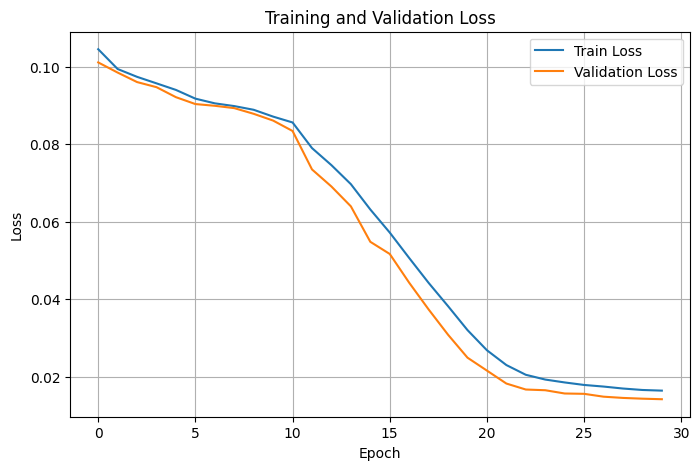

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# ---------- THRESHOLD ----------
# Compute reconstruction error (MAE) for validation benign set
val_pred = model.predict(X_val, batch_size=1024)
val_mae = np.mean(np.abs(val_pred - X_val), axis=(1,2))
threshold = float(np.percentile(val_mae, THRESHOLD_PERCENTILE))
print(f"Computed threshold (percentile {THRESHOLD_PERCENTILE}): {threshold}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Computed threshold (percentile 99): 0.14352912117078315


In [16]:
# ---------- EVALUATION ON TEST SET ----------
# Prepare ground-truth labels for test set: 0=benign, 1=anomaly
y_test = (~test_df[LABEL_COL].str.contains("Benign", case=False, na=False)).astype(int).values

# Predict on the test set
test_pred = model.predict(X_test, batch_size=1024)
test_mae = np.mean(np.abs(test_pred - X_test), axis=(1,2))
y_pred = (test_mae > threshold).astype(int)

# Confusion matrix & classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(y_test, y_pred, target_names=["Benign","Anomaly"]))

84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step
Confusion matrix:
 [[ 2016    21]
 [ 2077 81519]]
Classification report:
               precision    recall  f1-score   support

      Benign       0.49      0.99      0.66      2037
     Anomaly       1.00      0.98      0.99     83596

    accuracy                           0.98     85633
   macro avg       0.75      0.98      0.82     85633
weighted avg       0.99      0.98      0.98     85633



In [17]:
model.save("lstm_autoencoder.h5")


In [18]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [19]:
import json
with open("numeric_features.json", "w") as f:
    json.dump(numeric_features, f)


In [20]:
with open("threshold.json", "w") as f:
    json.dump({"threshold": threshold}, f)
